In [1]:
#pandas, para lectura de datos.
import pandas as pd 

#numpy,  carga de datos en memoria
import numpy as np

#matplotlib, para graficar.
import matplotlib.pyplot as plt 

#Sequential es fundamental para apilar capas que pueden conformar una red neuronal o simplemente una función matématica.   
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD

# Sklearn, para normalizar y segmentar els et de datos.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Para la gráfica que permitira hallar: precision y recall para determinar el umbral.
from sklearn.metrics import confusion_matrix, precision_recall_curve




In [2]:
# 1. Lectura de los datos.
# -----------------------------------------------

datos = pd.read_csv("creditcard.csv")
print(datos.head())

nr_clases = datos['Class'].value_counts(sort=True)
print(nr_clases)


# EL dataset hace referencia a registros de transacciones en europa para septiembre de 2013.
# Los valores de las variables de V1 a V28 estan transformadas utilizando PCA (para reducir la redundancia de información)
# por motivos de confidencialidad.

# La variable: time, indica los segundos transcurridos desde la generación del primer registro.
# mientras, amount, representa el monto de la transacción.

# En la variable: Class, existe la siguiente distribución: 
                                                            #normales: 284.315
                                                            #fraudulentas: 492

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

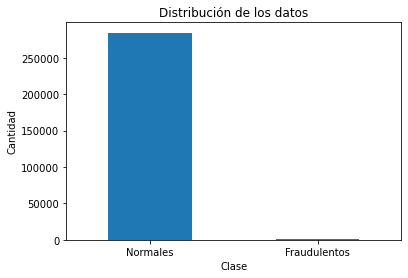

In [3]:
# 2. Análisis exploratorio de los datos.
# -----------------------------------------------

# Cantidad de registros normales vs. fraudulentos
nr_clases.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normales', 'Fraudulentos'])
plt.title("Distribución de los datos")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

#Existe un desbalance de las clases.

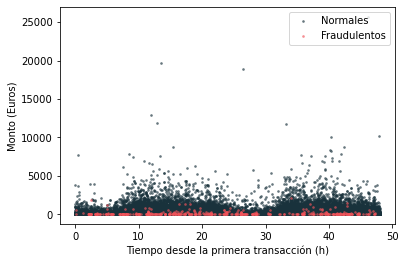

In [4]:
# Monto de las transacciones vs. el tiempo.


normales = datos[datos.Class==0]
fraudulentos = datos[datos.Class==1]
plt.scatter(normales.Time/3600, normales.Amount, 
	alpha = 0.5, c='#19323C', label='Normales', s=3)
plt.scatter(fraudulentos.Time/3600, fraudulentos.Amount, 
	alpha = 0.5, c='#F2545B', label='Fraudulentos', s=3)
plt.xlabel('Tiempo desde la primera transacción (h)')
plt.ylabel('Monto (Euros)')
plt.legend(loc='upper right')
plt.show()

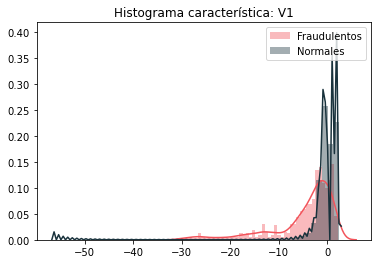

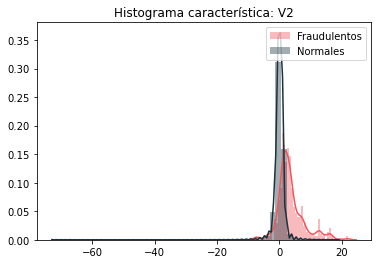

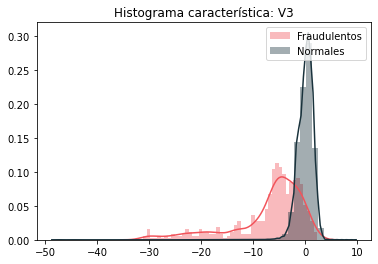

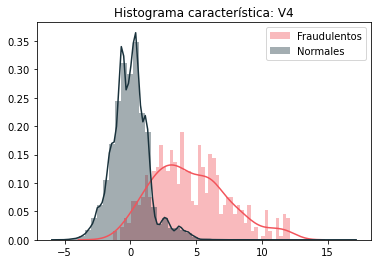

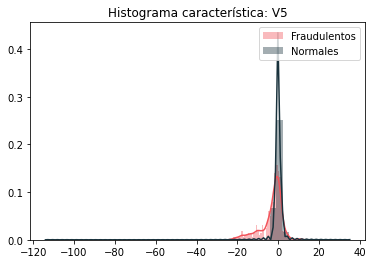

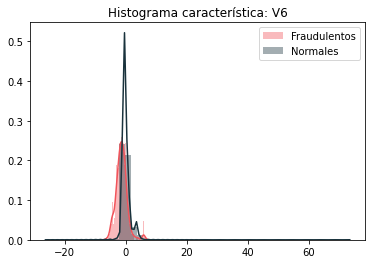

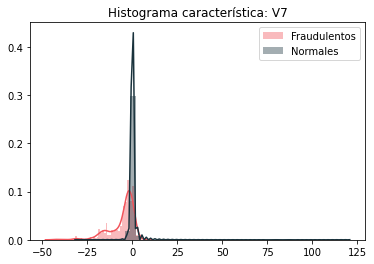

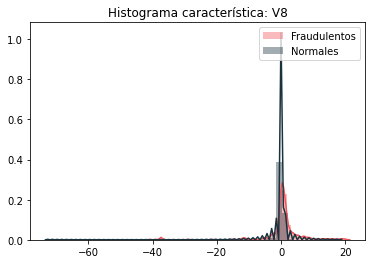

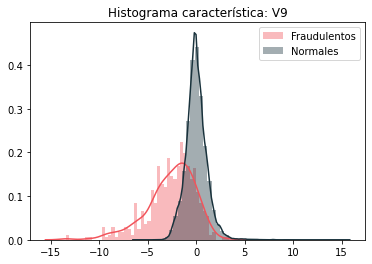

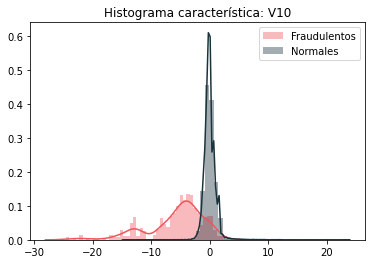

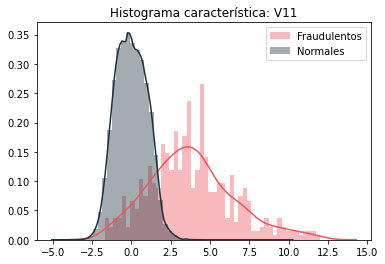

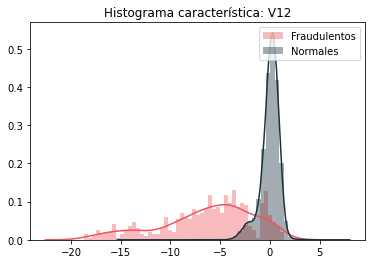

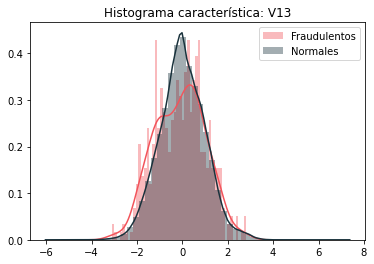

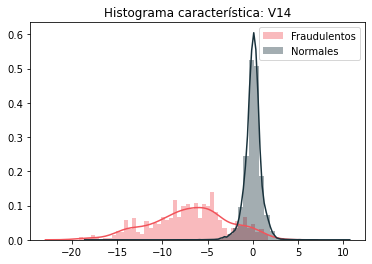

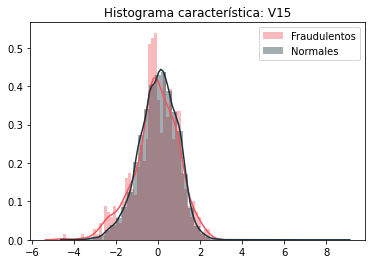

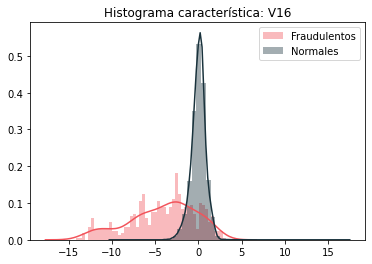

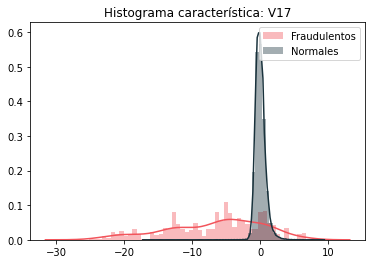

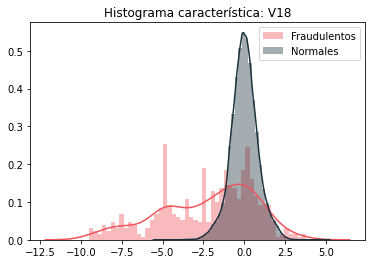

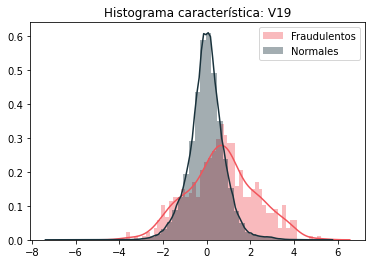

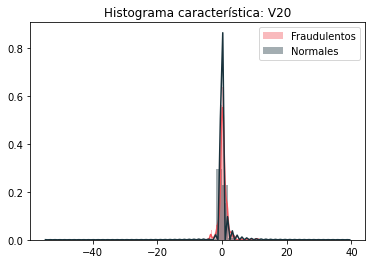

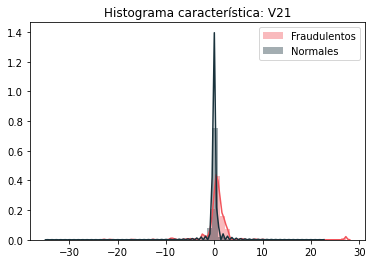

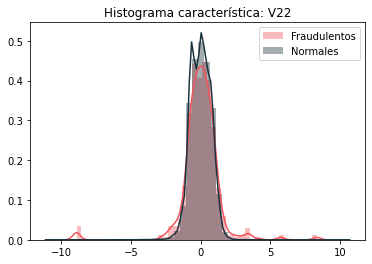

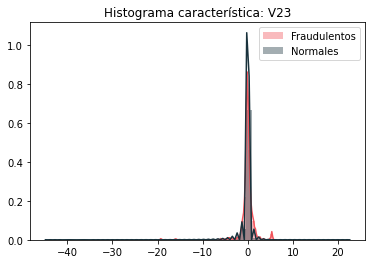

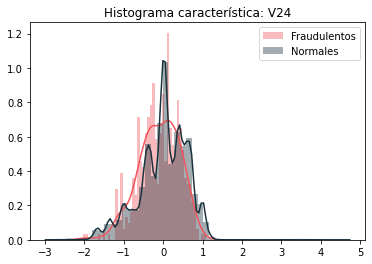

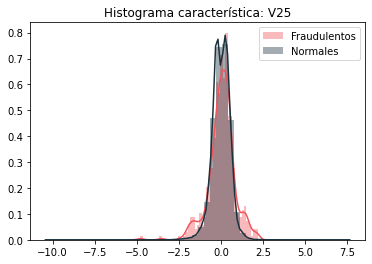

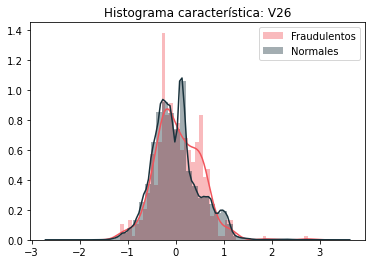

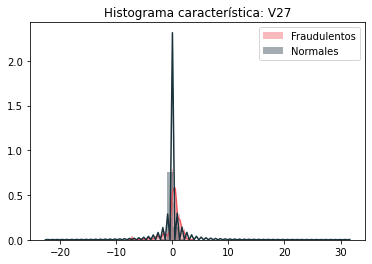

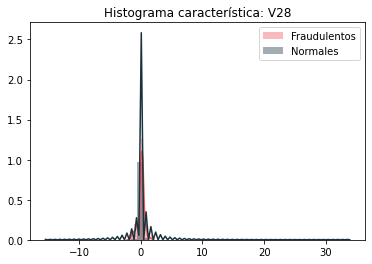

In [5]:
# Distribución de las variables: V1 a V28, entre normales y fraudulentos

import matplotlib.gridspec as gridspec
import seaborn as sns

v_1_28 = datos.iloc[:,1:29].columns
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(datos[v_1_28]):
    sns.distplot(datos[cn][datos.Class == 1], bins=50, 
    	label='Fraudulentos', color='#F2545B')
    sns.distplot(datos[cn][datos.Class == 0], bins=50, 
    	label='Normales', color='#19323C')
    plt.xlabel('')
    plt.title('Histograma característica: ' + str(cn))
    plt.legend(loc='upper right')
    plt.show()


In [6]:
# 3. Preprocesamiento
# -----------------------------------------------

#Eliminamos la variable: time, porque no aporta mayor información.
datos.drop(['Time'], axis=1, inplace=True)

#Normalizamos la varibale: amount, para que tenga media 0 y desviación estandar 1.
datos['Amount'] = StandardScaler().fit_transform(datos['Amount'].values.reshape(-1,1))

X_train, X_test = train_test_split(datos, test_size=0.2, random_state=42)

#El set de entrenamiento unicamente tendrña registros normales (Class == 0).
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

#En el set de validación / test si contendra  los dos tipos de clases (Class: 0 y 1).
Y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_test = X_test.values

In [7]:
# 4. AUTOENCODER: 29-20-14-20-29, tanh-relu-tanh-relu
# -----------------------------------------------
np.random.seed(5)

dim_entrada = X_train.shape[1]          # 29
capa_entrada = Input(shape=(dim_entrada,))

encoder = Dense(20, activation='tanh')(capa_entrada) #20
encoder = Dense(14, activation='relu')(encoder) #14

decoder = Dense(20, activation='tanh')(encoder) #20
decoder = Dense(29, activation='relu')(decoder) #29

autoencoder = Model(inputs=capa_entrada, outputs=decoder)

# El encoder permite pasar de unos datos de entrada de 29 variables a 14, para luego, 
# con el decoder pasar de 14, nuevamente a 29, por medio de la reconstrucción del dato.  

# El metodo model, permite a keras conectar las capas encoder y decoder.

#Entrenamiento

#Función de costo de perdida: mse (mean square error) y optimizador para minimizar esta funcion de
#costo: SGD, gradiante descendiente.

sgd = SGD(lr=0.01)
autoencoder.compile(optimizer='sgd', loss='mse')

n_iteraciones = 100
bach_size = 32 # 2^5

autoencoder.fit(X_train, X_train, epochs=n_iteraciones, batch_size=bach_size, shuffle=True, validation_data=(X_test,X_test), verbose=1)

# definimos x_train, tanto como el dato de entrada como de salida del modelo, por la carcteristicas
# del autoencoder.

Epoch 1/100
7108/7108 [==============================] - 5s 677us/step - loss: 0.9245 - val_loss: 0.8772
Epoch 2/100
7108/7108 [==============================] - 5s 682us/step - loss: 0.8208 - val_loss: 0.8313
Epoch 3/100
7108/7108 [==============================] - 5s 662us/step - loss: 0.7879 - val_loss: 0.8057
Epoch 4/100
7108/7108 [==============================] - 5s 654us/step - loss: 0.7643 - val_loss: 0.7825
Epoch 5/100
7108/7108 [==============================] - 5s 652us/step - loss: 0.7458 - val_loss: 0.7670
Epoch 6/100
7108/7108 [==============================] - 5s 652us/step - loss: 0.7321 - val_loss: 0.7547
Epoch 7/100
7108/7108 [==============================] - 5s 655us/step - loss: 0.7196 - val_loss: 0.7430
Epoch 8/100
7108/7108 [==============================] - 5s 653us/step - loss: 0.7090 - val_loss: 0.7347
Epoch 9/100
7108/7108 [==============================] - 5s 652us/step - loss: 0.7010 - val_loss: 0.7273
Epoch 10/100
7108/7108 [==============================]

7108/7108 [==============================] - 5s 659us/step - loss: 0.6220 - val_loss: 0.6547
Epoch 79/100
7108/7108 [==============================] - 5s 658us/step - loss: 0.6214 - val_loss: 0.6554
Epoch 80/100
7108/7108 [==============================] - 5s 656us/step - loss: 0.6213 - val_loss: 0.6543
Epoch 81/100
7108/7108 [==============================] - 5s 656us/step - loss: 0.6213 - val_loss: 0.6549
Epoch 82/100
7108/7108 [==============================] - 5s 667us/step - loss: 0.6210 - val_loss: 0.6629
Epoch 83/100
7108/7108 [==============================] - 5s 656us/step - loss: 0.6210 - val_loss: 0.6538
Epoch 84/100
7108/7108 [==============================] - 5s 653us/step - loss: 0.6207 - val_loss: 0.6568
Epoch 85/100
7108/7108 [==============================] - 5s 653us/step - loss: 0.6205 - val_loss: 0.6572
Epoch 86/100
7108/7108 [==============================] - 5s 654us/step - loss: 0.6207 - val_loss: 0.6535
Epoch 87/100
7108/7108 [==============================] - 5

(56962, 29)


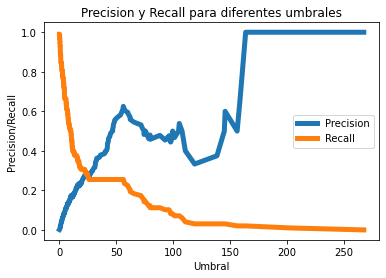

In [8]:
# 4. VALIDACIÓN
# -----------------------------------------------
np.random.seed(5)

# Predicción X_test -> Autoencoder -> X_pred
X_pred = autoencoder.predict(X_test)
mse_calculado = np.mean(np.power(X_test-X_pred,2), axis=1)
print(X_pred.shape)

# Elementos para determinar el umbral.
precision, recall, umbral = precision_recall_curve(Y_test, mse_calculado)

#Precision: True Positives / True Positives + False Positives
#Recall:    True Positives / True Positives + False Negatives 

plt.plot(umbral, precision[1:], label="Precision",linewidth=5)
plt.plot(umbral, recall[1:], label="Recall",linewidth=5)
plt.title('Precision y Recall para diferentes umbrales')
plt.xlabel('Umbral')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()


In [9]:
# Se requiere obtener un recall más elevado que la precisión, porque se requiere tener 
# el mayor numero de fraudes posibles.


umbral_fijo = 0.75
Y_pred = [1 if e > umbral_fijo else 0 for e in mse_calculado]

conf_matrix = confusion_matrix(Y_test, Y_pred)

print("Fila: Categoria Real. 1. Normales  2.Fraudulentas")
print("Columna: Categoria Predicha. 1. Normales  2.Fraudulentas")
print(conf_matrix)

Fila: Categoria Real. 1. Normales  2.Fraudulentas
Columna: Categoria Predicha. 1. Normales  2.Fraudulentas
[[49362  7502]
 [    7    91]]


In [10]:
# Se puede apreciar que se puede pronosticar 91 transacciones fraudulentas correctamente, teniendo.
# un 92,8 %.

# Recall:    91 / 91 + 7 = 92.8 %
# Precision: 91 / 91 + 7502 = 1.19 % 